In [63]:
import sqlite3
import numpy as np
import pandas as pd
import seaborn as sns

## Report on Data Quality
The goal of this challenge is to find data quality issues in the database of the fictional Company X, concerning some leading questions, that I will go through one by one.
</br>
</br>
I used DBeaver to get a general overview about the database and to try out some queries in advance before I implemented them in this notebook.

### Question 1: Are the costs in the 'api_adwords_costs' table fully covered in the 'session_sources' table? Any campaigns where you see issues?

To determine if all the advertising costs listed in the AdWords API (external data source) are fully covered in Company X's own database, I joined the tables and compared the cost's totals by making a new column for the difference.

Findings: The cost-per-click sums differ unsignificantly over a mayority of the campaigns. There is one campaign however, that the session sources table doesn't properly cover.


In [86]:
# connecting to the database and creating a cursor
conn = sqlite3.connect('challenge.db')
c = conn.cursor()

# specifying the query
query = '''WITH aggregated_costs AS (
SELECT session_sources.event_date, session_sources.campaign_id, 
	ROUND(SUM(session_sources.cpc),2) AS cpc_session_sources,
	ROUND(api_adwords_costs.cost,2) AS cpc_api_adwords
FROM api_adwords_costs 
	LEFT JOIN session_sources 
	ON session_sources.campaign_id = api_adwords_costs.campaign_id 
	AND session_sources.event_date = api_adwords_costs.event_date 
WHERE session_sources.campaign_id != 'notset'
GROUP BY session_sources.event_date, session_sources.campaign_id 
ORDER BY session_sources.event_date, session_sources.campaign_id
)
SELECT *, ROUND(aggregated_costs.cpc_api_adwords - aggregated_costs.cpc_session_sources,2) AS difference
FROM aggregated_costs'''
c.execute(query)

# fetching the column names by hand
columns = []
for ele in c.description:
    columns.append(ele[0])

# fetching the results
results = pd.DataFrame(c.fetchall(), columns=columns).sort_values(by=['difference'])
results

,event_date,campaign_id,cpc_session_sources,cpc_api_adwords,difference
325,2021-07-04,campaign_id_149,3555.79,3554.29,-1.50
425,2021-07-05,campaign_id_149,1504.89,1503.71,-1.18
1595,2021-07-17,campaign_id_149,1779.14,1778.15,-0.99
1304,2021-07-14,campaign_id_149,1655.94,1655.01,-0.93
1204,2021-07-13,campaign_id_149,1483.86,1483.03,-0.83
...,...,...,...,...,...
387,2021-07-04,campaign_id_79,0.00,474.39,474.39
1166,2021-07-12,campaign_id_79,0.00,487.64,487.64
1068,2021-07-11,campaign_id_79,0.00,489.73,489.73
1264,2021-07-13,campaign_id_79,0.00,500.65,500.65


Let's extract those campaigns, that ever had their advertising costs deviating by more than 5 Euros in one day and then sum up their total deviations from the extertal data source over the course of the whole month.

In [80]:
problematic_campaigns = results[results['difference'] > 5][['campaign_id','difference']]
problematic_campaigns.groupby(by="campaign_id").sum().sort_values(by=['difference'], ascending=False)

,difference
campaign_id,
campaign_id_79,11756.17
campaign_id_73,132.99
campaign_id_52,55.59
campaign_id_35,45.48
campaign_id_94,32.55
campaign_id_5,20.56
campaign_id_156,13.98
campaign_id_64,8.49
campaign_id_150,6.62


This is a list of the most deviating campaigns. Except for maybe the top 3, the deviations might be in an acceptable range for Company X.

The by fast most problematic inconsistency to be found here is in "campaign_id_79".

A little check confirms, that it's listed in the company's session_sources table, but without any assiciated costs.

In [88]:
# check on campaign_id_79

query = '''SELECT session_sources.event_date, session_sources.campaign_id, ROUND(SUM(session_sources.cpc),2) AS cpc_session_sources
FROM session_sources
WHERE session_sources.campaign_id = 'campaign_id_79'
GROUP BY session_sources.event_date, session_sources.campaign_id 
ORDER BY session_sources.event_date, session_sources.campaign_id '''
c.execute(query)

columns = []
for ele in c.description:
    columns.append(ele[0])

results = pd.DataFrame(c.fetchall(), columns=columns)
results

,event_date,campaign_id,cpc_session_sources
0,2021-07-01,campaign_id_79,0.0
1,2021-07-02,campaign_id_79,0.0
2,2021-07-03,campaign_id_79,0.0
3,2021-07-04,campaign_id_79,0.0
4,2021-07-05,campaign_id_79,0.0
5,2021-07-06,campaign_id_79,0.0
6,2021-07-07,campaign_id_79,0.0
7,2021-07-08,campaign_id_79,0.0
8,2021-07-09,campaign_id_79,0.0
9,2021-07-10,campaign_id_79,0.0


### Question 2: Are the conversions in the 'conversions' table stable over time? Any pattern?

We will group all the revenues over the dates when they were drawn and plot a chart, so we can visually see, if the revenues kept stable.

In [90]:
query = '''SELECT conv_date, ROUND(SUM(revenue),2) AS revenue_per_day
FROM conversions
GROUP BY conv_date  
'''
c.execute(query)
columns = []
for ele in c.description:
    columns.append(ele[0])
results = pd.DataFrame(c.fetchall(), columns=columns)
results

,conv_date,revenue_per_day
0,2021-07-15,48140.04
1,2021-07-16,38388.89
2,2021-07-17,34721.01
3,2021-07-18,74555.65
4,2021-07-19,41764.69
5,2021-07-20,37678.05
6,2021-07-21,37516.15
7,2021-07-22,38041.52
8,2021-07-23,36188.87
9,2021-07-24,31101.09


/tmp/ipykernel_58334/1339475041.py:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  chart.set_xticklabels(chart.get_xticklabels(), rotation=45);


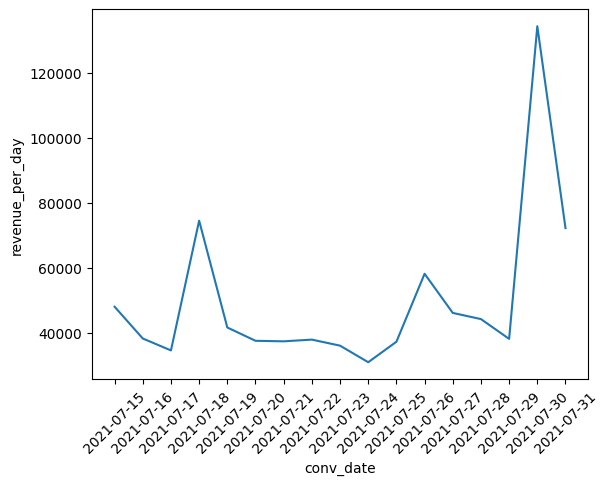

In [92]:
chart = sns.lineplot(x=results['conv_date'], y=results['revenue_per_day'])
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);

The conversion seems to have increased towards the end of the month. However, we would have to consider several months to deduce if 'end of the month' makes any pattern, because the increase could equally well be due to the beginning holiday season or any other reason.

Also, on weekends the revenue for those 16 days was higher. But again, if this makes a pattern needs to be verified over a longer period of time.

### Question 3: Double check conversions ('conversions' table) with backend ('conversions_backend' table), any issues?

In [6]:
query = '''SELECT conversions_backend.conv_date, 
ROUND(SUM(conversions_backend.revenue),2) AS revenue_backend, 
ROUND(SUM(conversions.revenue),2) AS revenue_reported,
ROUND(SUM(conversions_backend.revenue),2)-ROUND(SUM(conversions.revenue),2) AS difference
FROM conversions_backend JOIN conversions
ON conversions_backend.conv_id = conversions.conv_id
GROUP BY conversions_backend.conv_date   
'''
c.execute(query)
columns = []
for ele in c.description:
    columns.append(ele[0])
results = pd.DataFrame(c.fetchall(), columns=columns)
results

,conv_date,revenue_backend,revenue_reported,difference
0,2021-07-15,48711.87,48140.04,571.83
1,2021-07-16,38979.81,38388.89,590.92
2,2021-07-17,35005.59,34721.01,284.58
3,2021-07-18,75421.04,74555.65,865.39
4,2021-07-19,42501.31,41764.69,736.62
5,2021-07-20,38286.54,37678.05,608.49
6,2021-07-21,37881.16,37516.15,365.01
7,2021-07-22,38967.53,38041.52,926.01
8,2021-07-23,36302.98,36188.87,114.11
9,2021-07-24,31355.41,31101.09,254.32


The reported revenues are lower than the revenues in the tables derived directly from the backend. Presumably there are some instances missing. Let's check for that.

In [7]:
query = '''SELECT COUNT(*)
FROM conversions_backend
'''
c.execute(query)
backend = c.fetchone()[0]

query = '''SELECT COUNT(*)
FROM conversions
'''
c.execute(query)
reported = c.fetchone()[0]

print(f'There are {backend} rows in the "conversions_backend" table and only {reported} rows in the reported \
"conversions" table. This means, in the reported table there are events missing.')

There are 17283 rows in the "conversions_backend" table and only 16954 rows in the reported "conversions" table. This means, in the reported table there are events missing.


### Question 4: Are attribution results consistent? Do you find any conversions where the 'ihc' values don't make sense?

### (Bonus) Do we have an issue with channeling? Are the number of sessions per channel stable over time?

### (Bonus) Any other issues?

Generally, relational databases facilitate data consistency by keeping information on one and the same thing in a single place and then linking tables if necessary. Company X however doesn't take whole use of this opportunity which leads to some problems with data consistance. Some suggestions to restucture the database, so that data quality is keeping itself automatically:

1. Information on the costs of the adds should be kept in one place only (not in two different tables), so that inconsistency problems couldn't even accur. The cost of the adds can be saved per click and accumulated (usind a groupby SQL query) per day if needed.       -----> attention: the second table is an external data source

2. The "campaign_id" in the "session_sources" table should be fully matched with "campaign_name". This way it will be easier to query SQL commands in future, without the need to convert into pandas dataframes to do the matching there. Since "campaign_name" isn't occuring anywhere else in the database, the company could also consider to entirely delete it, if not explicitely needed. This would reduce future risk of lacking data consistency.


In [ ]:
# closing database, though in this case we did only read from it, so it's not really necessary
c.close()